# Try to recover performance on unlearned task adversarially

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('acdcpp/Automatic-Circuit-Discovery/')
sys.path.append('acdcpp/')
from acdc import TLACDCExperiment
from acdcpp.ACDCPPExperiment import ACDCPPExperiment

import os
import sys
import re

# import acdc
from acdc.TLACDCExperiment import TLACDCExperiment
from acdc.acdc_utils import TorchIndex, EdgeType
import numpy as np
import torch as t
from torch import Tensor
import einops
import itertools

from transformer_lens import HookedTransformer, ActivationCache

import tqdm.notebook as tqdm
import plotly
from rich import print as rprint
from rich.table import Table

from jaxtyping import Float, Bool
from typing import Callable, Tuple, Union, Dict, Optional

import torch
import pickle

device = t.device('cuda') if t.cuda.is_available() else t.device('cpu')
print(f'Device: {device}')

Device: cuda


## First, load model back in

In [2]:
edge_masks = True
use_uniform = False
ioi_uniform_type = "IO_S"
weight_masks_attn = False
weight_masks_mlp = False
train_base_weights = False
localize_acdcpp = True

run_name = f"{use_uniform=}_"
if use_uniform:
    run_name += f"_{ioi_uniform_type=}_"
run_name += f"{edge_masks=}_{weight_masks_attn=}_{weight_masks_mlp=}_{train_base_weights=}_{localize_acdcpp=}"

epoch = 200
# want to open masks/{run_name}/mask_params_epoch=200.pt
mask_params_path = f'masks/{run_name}/mask_params_epoch={epoch}.pt'
mask_params = torch.load(mask_params_path, map_location=device)

In [3]:
from cb_utils.models import load_demo_gpt2, tokenizer
model = load_demo_gpt2(means=False, edge_masks=edge_masks, weight_masks_attn=weight_masks_attn, weight_masks_mlp=weight_masks_mlp, train_base_weights=train_base_weights)
from tasks import IOITask
task = IOITask(batch_size=16, tokenizer=tokenizer, device=device)
print(task.get_test_accuracy(model))

Using device: cuda:0
1.0


In [73]:
# load mask params into model
for k, v in model.named_parameters():
    if v.requires_grad:
        mask = mask_params.pop(0)
        v.data = mask

In [74]:
task = IOITask(batch_size=16, tokenizer=tokenizer, device=device)
print(task.get_test_accuracy(model))

0.5


## Adversarial Retraining

In [ ]:
# try finetuning model (finetune only weights), for now only finetune the attention and mlps
from torch.optim import AdamW
from cb_utils.learn_mask import train_masks

for name, param in model.named_parameters():
    if "attn.W_Q" in name or "attn.W_K" in name or "attn.W_V" in name or "attn.W_O" in name or "mlp.W_in" in name or "mlp.W_out" in name:
        param.requires_grad = True
    elif "attn.b_Q" in name or "attn.b_K" in name or "attn.b_V" in name or "attn.b_O" in name or "mlp.b_in" in name or "mlp.b_out" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
# make param_names, mask_params
param_names = [n for n, p in model.named_parameters() if p.requires_grad]
mask_params = [p for n, p in model.named_parameters() if p.requires_grad]

lr = 1e-2
weight_decay = .1
optimizer = torch.optim.AdamW(mask_params, lr=lr, weight_decay=weight_decay)

In [ ]:
from tasks import IOITask, OWTTask
owt_task = OWTTask(batch_size=16, tokenizer=tokenizer, device=device)
# train_tasks = {"ioi": task, "owt": owt_task}
# task_weights = {"ioi": 1.0, "owt": 1.0}
train_tasks = {"ioi": task}
task_weights = {"ioi": 1.0}
# eval_tasks = {"ioi": task}
eval_tasks = {"ioi": task, "owt": owt_task}
train_losses, test_losses = train_masks(
    model,
    optimizer=optimizer,
    tasks=train_tasks,
    task_weights=task_weights,
    eval_tasks=eval_tasks,
    num_epochs=100,
    param_names=param_names,
    mask_params=mask_params,
    steps_per_epoch=10,
    evaluate_every=2,
    num_eval_steps=10,
    discretize_every=None,
    save_every=None,
)

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)
100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


In [ ]:
test_losses.keys()

dict_keys(['ioi', 'ioi_acc', 'owt', 'owt_acc'])

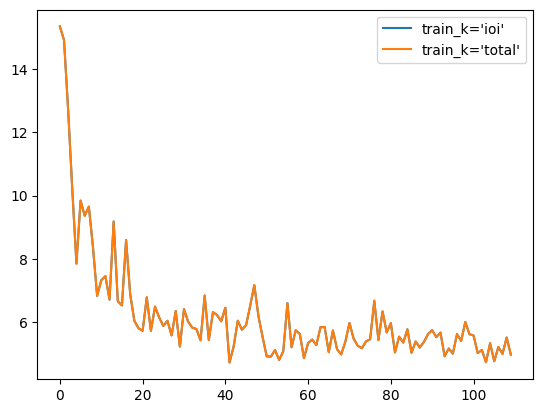

In [ ]:
# plot train_losses, test_losses
import matplotlib.pyplot as plt

for k, v in train_losses.items():
    plt.plot([x[2] for x in v], label=f"train_{k=}")
plt.legend()
plt.show()


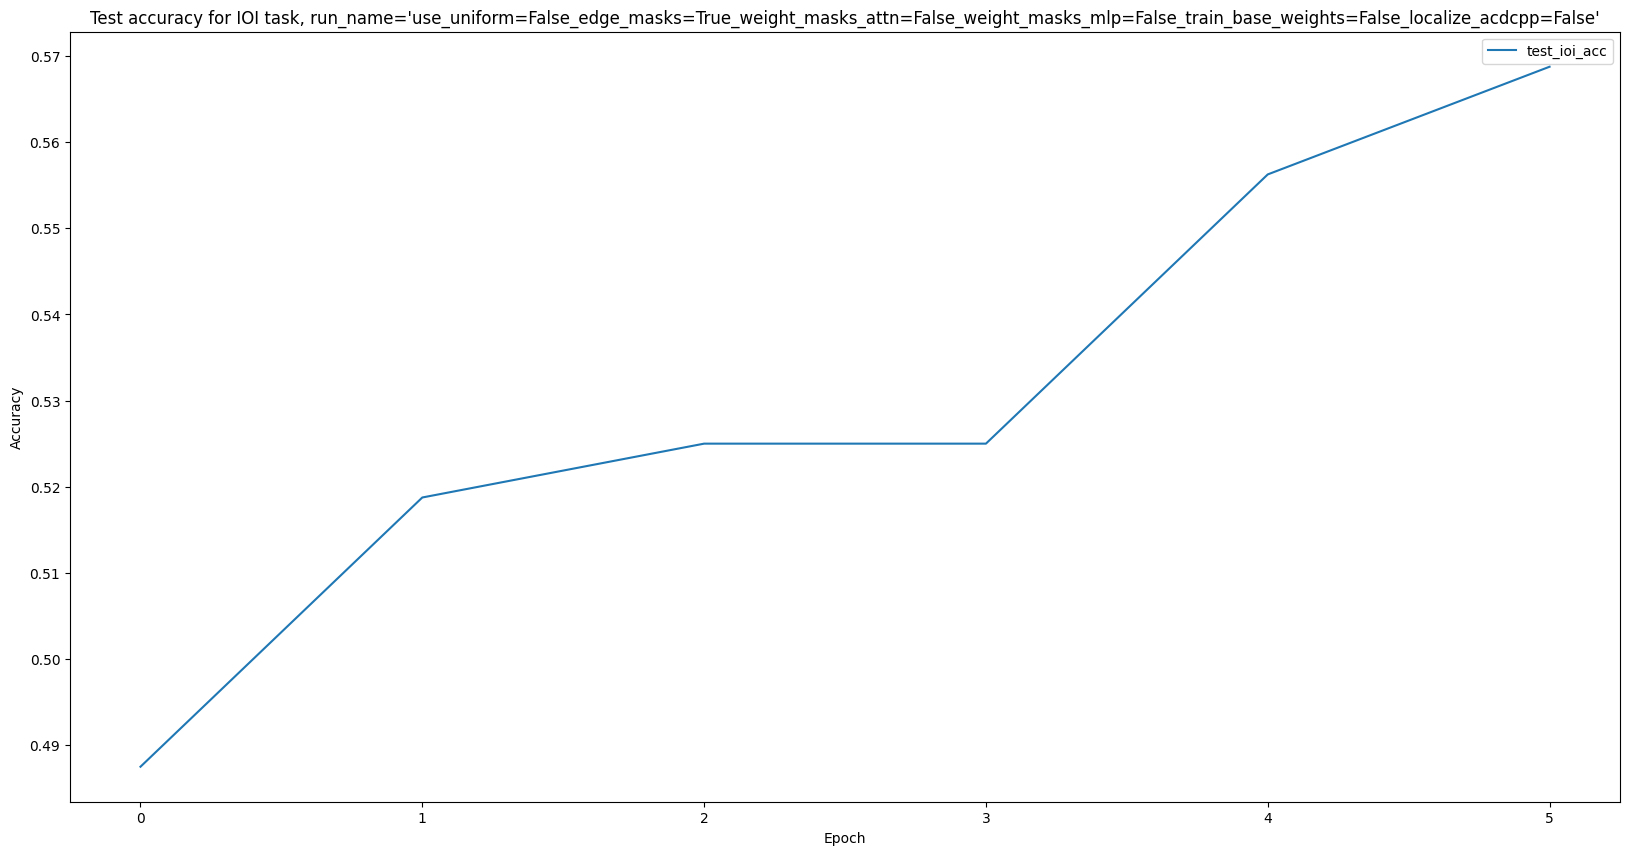

In [ ]:
# plt.plot([x.item() for x in test_losses["ioi"]], label="test_ioi_loss")
# plot make figure size
plt.figure(figsize=(20, 10))
plt.title(f"Test accuracy for IOI task, {run_name=}")
plt.plot([x for x in test_losses["ioi_acc"]], label="test_ioi_acc")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
model.blocks[8].edge_mask_attentions

Parameter containing:
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0', requires_grad=True)

In [ ]:
print((model.blocks[11].edge_mask_attentions == 0).sum())

tensor(0, device='cuda:0')


In [ ]:
model.blocks[11].edge_mask_attentions

Parameter containing:
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0')

In [ ]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

output_mask True
embed.W_E False
pos_embed.W_pos False
ln_final.w False
ln_final.b False
unembed.W_U False
unembed.b_U False
blocks.0.edge_mask_attentions True
blocks.0.edge_mask_mlp True
blocks.0.ln1.w False
blocks.0.ln1.b False
blocks.0.attn.W_Q False
blocks.0.attn.b_Q False
blocks.0.attn.W_K False
blocks.0.attn.b_K False
blocks.0.attn.W_V False
blocks.0.attn.b_V False
blocks.0.attn.W_O False
blocks.0.attn.b_O False
blocks.0.ln2.w False
blocks.0.ln2.b False
blocks.0.mlp.W_in False
blocks.0.mlp.b_in False
blocks.0.mlp.W_out False
blocks.0.mlp.b_out False
blocks.1.edge_mask_attentions True
blocks.1.edge_mask_mlp True
blocks.1.ln1.w False
blocks.1.ln1.b False
blocks.1.attn.W_Q False
blocks.1.attn.b_Q False
blocks.1.attn.W_K False
blocks.1.attn.b_K False
blocks.1.attn.W_V False
blocks.1.attn.b_V False
blocks.1.attn.W_O False
blocks.1.attn.b_O False
blocks.1.ln2.w False
blocks.1.ln2.b False
blocks.1.mlp.W_in False
blocks.1.mlp.b_in False
blocks.1.mlp.W_out False
blocks.1.mlp.b_out False
b

## Extraction Attacks
from https://arxiv.org/pdf/2309.17410.pdf

In [5]:
# logit lens: decode residual stream
from fancy_einsum import einsum

from collections import defaultdict
def layer_hook_function(layer, outputs):
    def hook_fn(module, input, output):
      outputs[layer].append(output.clone().detach())
      return output
    return hook_fn

def get_residuals(batch_text, model):
    outputs = defaultdict(list)
    hooks = []
    for layer, block in enumerate(model.blocks):
        hook_fn = layer_hook_function(layer, outputs=outputs)
        hook_applied = block.register_forward_hook(hook_fn)
        hooks.append(hook_applied)

    for prompt in batch_text:
        tokenized = tokenizer(prompt, return_tensors="pt").input_ids
        model(tokenized)
    
    for hook in hooks:
        hook.remove()
    
    return outputs



def get_logits(model, residual):
    num_components = residual.shape[-2]
    masked_resid = einsum("batch position prev_head_idx d_model, prev_head_idx -> batch position d_model", residual, model.output_mask[:num_components])
    normalized_resid = model.ln_final(masked_resid)
    logits = model.unembed(normalized_resid)
    return logits

In [40]:
task = IOITask(batch_size=64, tokenizer=tokenizer, device=device)
batch = task.get_batch()
outputs = get_residuals(batch['text'], model)

In [50]:
decode_layer = 9
logits = get_logits(model, outputs[decode_layer][0])[0, -1]
print(batch['text'][0])
print(f"Decoding at layer {decode_layer}, token: {logits.argmax(-1)}, name: {tokenizer.decode(logits.argmax(-1))}")

Then, Graham and Amy went to the store. Amy gave a snack to
Decoding at layer 9, token: 11520, name:  Graham


In [44]:
import torch.nn.functional as F
import pandas as pd

n_layers = 12

# Initialize an empty DataFrame with MultiIndex
columns = pd.MultiIndex.from_product([range(n_layers), ['io_logprob', 's_logprob', 'io_pos']], names=['Layer', 'Metric'])
df = pd.DataFrame(columns=columns)

for point_idx in range(len(outputs[0])):
    io_token = tokenizer(" "+batch['IO'][point_idx])['input_ids'][-1]
    s_token = tokenizer(" "+batch['S'][point_idx])['input_ids'][-1]
    print(f"IO token: {io_token}, S token: {s_token}")
    data = {}  # This will hold the data for this point_idx
    for decode_layer in range(n_layers):
        with torch.no_grad():
            logits = get_logits(model, outputs[decode_layer][point_idx])[0, -1]
            logprobs = F.softmax(logits, dim=-1).log()
            io_logprob = logprobs[io_token].item()
            s_logprob = logprobs[s_token].item()
            io_s_logit_diff = (logits[io_token] - logits[s_token]).item()
            # Add the metrics to the data dictionary
            data[(decode_layer, 'io_logprob')] = io_logprob
            data[(decode_layer, 's_logprob')] = s_logprob
            
            # if io_logprob is the nth highest, store n
            io_pos = (logprobs >= io_logprob).sum().item()
            data[(decode_layer, 'io_pos')] = io_pos

    # Add the data for this point_idx to the DataFrame
    # df = df.append(pd.Series(data, name=point_idx))
    df.loc[point_idx] = pd.Series(data, name=point_idx)

# Now df holds the data for all point_idx and layers
display(df)

IO token: 11520, S token: 14235
IO token: 7859, S token: 9953
IO token: 10592, S token: 14316
IO token: 14316, S token: 17826
IO token: 8049, S token: 10674
IO token: 14862, S token: 10174
IO token: 5335, S token: 8982
IO token: 9308, S token: 10831
IO token: 12803, S token: 3977
IO token: 6858, S token: 12382
IO token: 12139, S token: 11288
IO token: 12969, S token: 8078
IO token: 14328, S token: 11465
IO token: 11465, S token: 12806
IO token: 32355, S token: 14006
IO token: 11520, S token: 16753
IO token: 18501, S token: 6047
IO token: 9533, S token: 5199
IO token: 7516, S token: 7939
IO token: 10888, S token: 16753
IO token: 32355, S token: 10443
IO token: 5278, S token: 16556
IO token: 9925, S token: 5658
IO token: 3619, S token: 11325
IO token: 8239, S token: 10805
IO token: 5199, S token: 7516
IO token: 27599, S token: 3700
IO token: 16738, S token: 12803
IO token: 8121, S token: 27599
IO token: 14200, S token: 10948
IO token: 3362, S token: 11336
IO token: 11563, S token: 11735


Layer          0                              1                       \
Metric io_logprob  s_logprob   io_pos io_logprob  s_logprob   io_pos   
0      -13.795076 -16.711250   4126.0 -15.626342 -17.459341   5766.0   
1      -15.756991 -17.759283  10816.0 -16.464466 -18.287277   9779.0   
2      -15.956060 -14.785284  11405.0 -16.295124 -15.887707   8154.0   
3      -14.549412 -15.837860   7087.0 -15.629242 -16.485245   6511.0   
4      -12.900530 -15.496077   2820.0 -13.786409 -16.201172   2667.0   
..            ...        ...      ...        ...        ...      ...   
59     -13.410023 -14.166056   3850.0 -14.873598 -14.890509   4895.0   
60     -14.482701 -16.058638   6270.0 -15.773262 -17.317068   7173.0   
61     -16.259279 -15.858704  13611.0 -17.554670 -16.714626  13453.0   
62     -16.151695 -16.494417  12398.0 -16.482479 -17.139660   9979.0   
63     -16.176004 -14.310236  12485.0 -17.094286 -15.357088  10524.0   

Layer          2                              3   ...      8          9   \
Metric io_logprob  s_logprob   io_pos io_logprob  ...  io_pos io_logprob   
0      -14.141641 -17.034191   3361.0 -13.088396  ...   225.0  -0.007672   
1      -15.933012 -16.627058   8711.0 -14.817903  ...  1668.0  -5.637720   
2      -15.285396 -15.099224   5900.0 -15.683594  ...   691.0  -0.000183   
3      -14.681203 -15.465257   5235.0 -14.066611  ...   353.0  -0.007757   
4      -13.567959 -15.407816   2959.0 -13.767862  ...  1128.0  -0.290256   
..            ...        ...      ...        ...  ...     ...        ...   
59     -12.708001 -15.193339   2252.0 -12.460541  ...   321.0  -0.013256   
60     -13.555600 -15.921246   3070.0 -15.600119  ...   186.0  -0.000309   
61     -17.190432 -16.753372  13066.0 -20.148886  ...  3869.0  -0.121120   
62     -15.504680 -16.935246   6954.0 -16.082823  ...    63.0  -0.007859   
63     -16.098341 -15.112209   7447.0 -16.740665  ...   171.0  -0.000006   

Layer                            10                           11            \
Metric  s_logprob io_pos io_logprob  s_logprob io_pos io_logprob s_logprob   
0      -14.626765    1.0  -0.011566  -7.967254    1.0  -0.808614 -3.388014   
1       -4.322687   24.0  -0.203376  -4.559650    1.0  -2.677346 -3.534478   
2      -13.464317    1.0  -0.000845  -8.632147    1.0  -0.423985 -3.293607   
3       -8.326293    1.0  -0.003044  -8.096953    1.0  -0.491946 -3.210726   
4       -4.528987    1.0  -0.092597  -3.831843    1.0  -1.189826 -3.054847   
..            ...    ...        ...        ...    ...        ...       ...   
59      -9.010766    1.0  -0.017012  -4.803420    1.0  -0.890672 -2.882929   
60     -10.879007    1.0  -0.001310  -8.701030    1.0  -0.330781 -4.272344   
61      -9.723195    1.0  -0.003179 -10.028696    1.0  -0.573833 -4.743049   
62      -6.080406    1.0  -0.017308  -5.010961    1.0  -1.065467 -2.901596   
63     -19.057732    1.0  -0.000033 -14.371543    1.0  -0.115675 -5.505850   

Layer          
Metric io_pos  
0         1.0  
1         2.0  
2         1.0  
3         1.0  
4         1.0  
..        ...  
59        1.0  
60        1.0  
61        1.0  
62        1.0  
63        1.0  

[64 rows x 36 columns]

### Attack 1: plot ave prob of IO token against layer

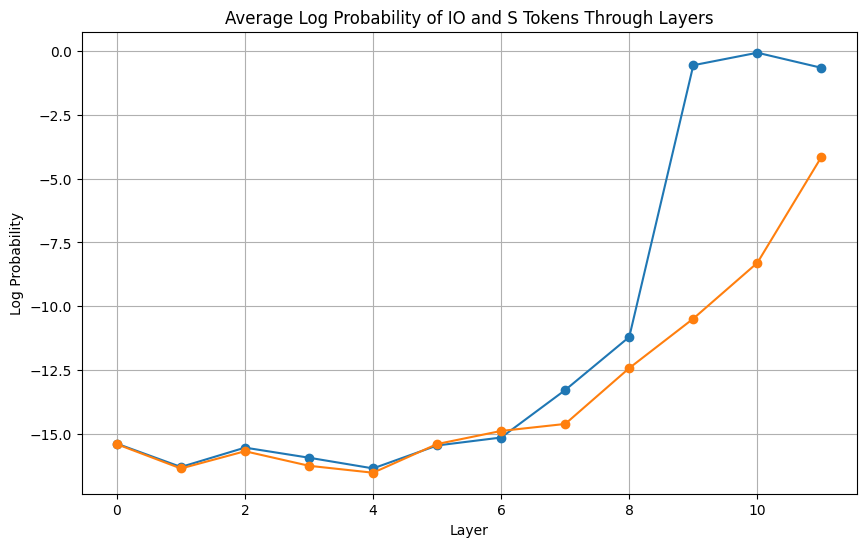

In [45]:
import matplotlib.pyplot as plt

use_logprob = True

# Calculate the average log-probability of the IO token for each layer
if use_logprob:
    avg_io_prob = df.xs('io_logprob', level='Metric', axis=1).mean()
    avg_s_prob = df.xs('s_logprob', level='Metric', axis=1).mean()
else:
    # take exp of logprobs
    avg_io_prob = df.xs('io_logprob', level='Metric', axis=1).apply(np.exp).mean()
    avg_s_prob = df.xs('s_logprob', level='Metric', axis=1).apply(np.exp).mean()
    
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(avg_io_prob.index, avg_io_prob.values, marker='o', label='IO')
plt.plot(avg_s_prob.index, avg_s_prob.values, marker='o', label='S')
plt.xlabel('Layer')
if use_logprob:
    plt.ylabel('Log Probability')
    plt.title('Average Log Probability of IO and S Tokens Through Layers')
else:
    plt.ylabel('Probability')
    plt.title('Average Probability of IO and S Tokens Through Layers')
plt.grid(True)
plt.show()

### Attack 2: plot average or median position of IO token against layer
This tells you approximately what top-"k" you need to find the IO token in the correct layer

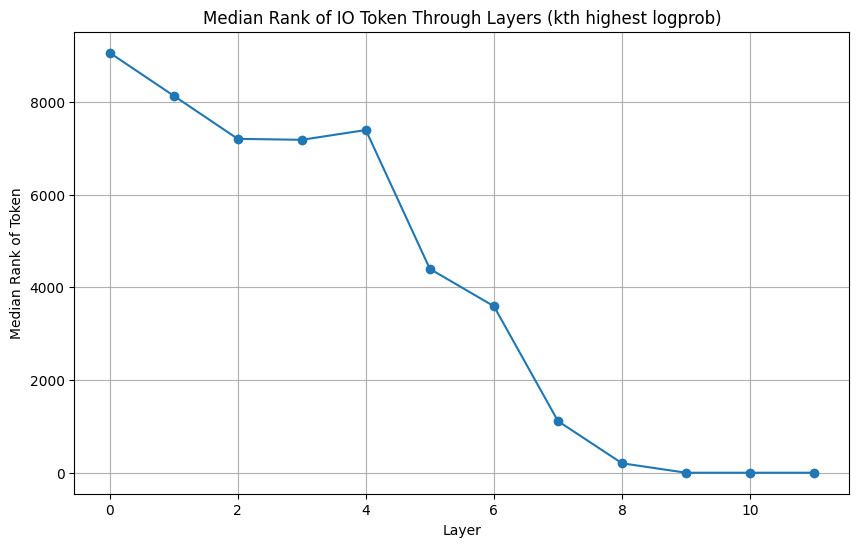

In [46]:
# Plot median position of IO token against layer

# Calculate the median position of the IO token for each layer
median_io_pos = df.xs('io_pos', level='Metric', axis=1).median()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(median_io_pos.index, median_io_pos.values, marker='o')
plt.xlabel('Layer')
plt.ylabel('Median Rank of Token')
plt.title('Median Rank of IO Token over all Tokens')
plt.grid(True)
plt.show()

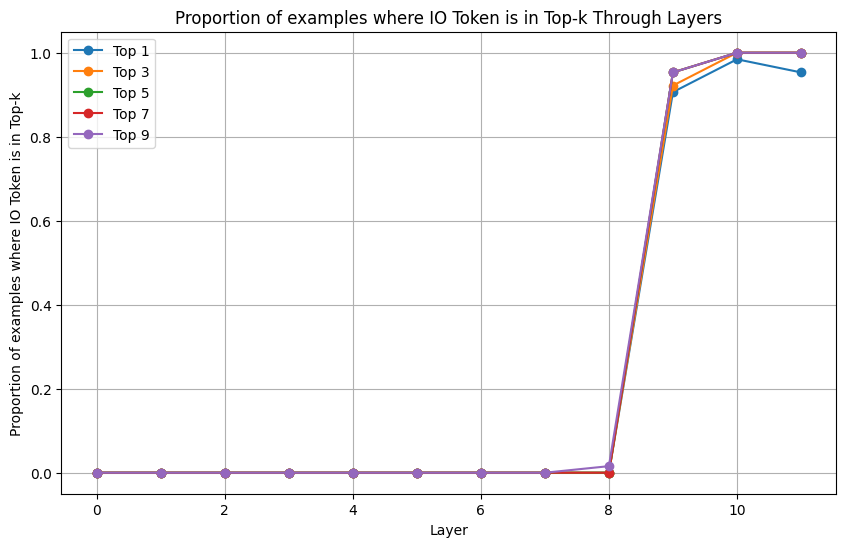

In [47]:
# Given top-k, what proportion of the time is the IO token in the top-k?

def get_top_k_accuracy(df, k):
    # Calculate the proportion of the time the IO token is in the top-k
    top_k = df.xs('io_pos', level='Metric', axis=1) <= k
    top_k_accuracy = top_k.mean()
    return top_k_accuracy

# Create the plot
plt.figure(figsize=(10, 6))
for k in range(1, 11, 2):
    top_k_accuracy = get_top_k_accuracy(df, k)
    plt.plot(top_k_accuracy.index, top_k_accuracy.values, marker='o', label=f'Top {k}')

plt.xlabel('Layer')
plt.ylabel('Proportion')
plt.title('Proportion of samples where IO Token is in Top-k tokens')
plt.grid(True)
plt.legend()
plt.show()

### Attack 3: Probability Delta
Deleted answer may quickly rise and fall in probability, so rank order differences in the probs of each token between successive layers

In [51]:
use_logprob = True
vocab_size = tokenizer.vocab_size
use_abs = True

# Initialize an empty DataFrame with MultiIndex for 11 layers
columns = pd.MultiIndex.from_product([range(11), ['io_diff_rank']], names=['Layer', 'Metric'])
df_diff = pd.DataFrame(columns=columns)

for point_idx in range(len(outputs[0])):
    io_token = tokenizer(" "+batch['IO'][point_idx])['input_ids'][-1]
    data = {}  # This will hold the data for this point_idx
    probs_tensor = torch.zeros(12, tokenizer.vocab_size)
    for decode_layer in range(12):
        with torch.no_grad():
            logits = get_logits(model, outputs[decode_layer][point_idx])[0, -1]
            logprobs = F.softmax(logits, dim=-1)
            if use_logprob:
                probs_tensor[decode_layer] = logprobs
            else:
                probs_tensor[decode_layer] = logprobs.exp()

    # probability of IO token should drop from layer n to n+1, so probs[n+1] - probs[n] should be negative, find the most negative or just abs
    if use_abs:
        diff = (probs_tensor[1:] - probs_tensor[:-1]).abs()  # shape (11, vocab_size)
    else:
        diff = probs_tensor[:-1] - probs_tensor[1:] # larger = higher drop

    print(diff.shape)
    io_diffs = diff[:, io_token]
    for layer_diff_index in range(11):
        io_diff = io_diffs[layer_diff_index]
        io_diff_rank = (diff[layer_diff_index] >= io_diff).sum().item()
        # Add the metric to the data dictionary
        data[(layer_diff_index, 'io_diff_rank')] = io_diff_rank
    # Add the data for this point_idx to the DataFrame
    # df_diff = df_diff.append(pd.Series(data, name=point_idx))
    df_diff.loc[point_idx] = pd.Series(data, name=point_idx)

# Now df_diff holds the data for all point_idx and layers
display(df_diff)

torch.Size([11, 50257])


TypeError: new(): invalid data type 'str'

### Get attack performances
As per the paper, get the proportion of times the IO token is in the candidate set, with the candidate set being constructed from either topk logprobs or topk diffs. As input, use L (which layers to analyze) and k, with a bound of |L|*k <= B (budget).

In [ ]:
test_

In [ ]:
budget = 20
lk_combos = [(1, 20), (2, 10), (4, 5), (5, 4), (10, 2)] # first number is num layers to look at, second number is num tokens to look at
